# Подключаем гугл диск

In [59]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# Распаковка данных

In [60]:
# !unzip -n "/content/gdrive/MyDrive/ups_2022_circle/circle_data.zip" -d "/content/gdrive/MyDrive/ups_2022_circle/data"

In [61]:
# ! cp -a '/content/gdrive/MyDrive/ups_2022_circle/data/ups_2022_circle/train_1/circle/.' '/content/gdrive/MyDrive/ups_2022_circle/data/train/circle/' 

# Подгружаем зависимости

In [62]:
! pip3 install torch torchvision torchaudio

# На CUDA будет побыстрее

In [63]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [64]:
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [65]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Nov 19 18:04:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |   1595MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [66]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [67]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

# Удобно подавать данные, обёрнутые в датасет, приведенные к одному формату - тензору

In [68]:
class StrawberryDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Grayscale() 
        ])
        transform_wb = transforms.ToTensor()
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        try: 
          x = transform(x)
        except:
          x = transform_wb(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

# Подгружаем данные с трех разных датасетов 

In [69]:
TRAIN_DIR_1 = Path('/content/gdrive/MyDrive/agrocode/data_3')
# TEST_DIR_1 = Path('/content/gdrive/MyDrive/ups_2022_circle/data/ups_2022_circle/valid_1')

# TRAIN_DIR_2 = Path('/content/gdrive/MyDrive/ups_2022_circle/data/ups_2022_circle/train_2')
# TEST_DIR_2 = Path('/content/gdrive/MyDrive/ups_2022_circle/data/ups_2022_circle/valid_2')

# TRAIN_DIR_3 = Path('/content/gdrive/MyDrive/ups_2022_circle/data/ups_2022_circle/train_3')
# TEST_DIR_3 = Path('/content/gdrive/MyDrive/ups_2022_circle/data/ups_2022_circle/valid_3')

train_val_files = sorted(list(TRAIN_DIR_1.rglob('*.jpg')) + list(TRAIN_DIR_1.rglob('*.JPG'))) #+ list(TRAIN_DIR_2.rglob('*.png')) + list(TRAIN_DIR_3.rglob('*.png')))
# test_files = sorted(list(TEST_DIR_1.rglob('*.jpg'))) #+ list(TEST_DIR_2.rglob('*.png')) + list(TEST_DIR_3.rglob('*.png')))

In [70]:
len(train_val_files)

1565

In [71]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

In [72]:
val_dataset = StrawberryDataset(val_files, mode='val')

In [73]:
len(val_dataset)

313

# Попробуем простую архитектурку

In [74]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [75]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [76]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [104]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    max_acc = 0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion) 
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            if val_acc> max_acc:
              max_acc = val_acc
              torch.save(model.state_dict(), '/content/gdrive/MyDrive/agrocode/weights/simple_cnn_{}'.format(round(int(max_acc)), 3))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [105]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

# Будем решать более комплексную задачу, чем поставлена в задании - классифицировать фигуры по 2 классам

In [109]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :2
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_feat

# Подготовим датасеты

In [110]:
if val_dataset is None:
    val_dataset = StrawberryDataset(val_files, mode='val')
    
train_dataset = StrawberryDataset(train_files, mode='train')

# Обучим наше чудо

In [111]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=20, batch_size=64)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.6142787617235519


epoch:   5%|▌         | 1/20 [00:07<02:25,  7.68s/it]


Epoch 001 train_loss: 0.6143     val_loss 0.5992 train_acc 0.7085 val_acc 0.7093
loss 0.6004910095812033


epoch:  10%|█         | 2/20 [00:15<02:16,  7.60s/it]


Epoch 002 train_loss: 0.6005     val_loss 0.5910 train_acc 0.7085 val_acc 0.7093
loss 0.5839178877326247


epoch:  15%|█▌        | 3/20 [00:22<02:08,  7.55s/it]


Epoch 003 train_loss: 0.5839     val_loss 0.5518 train_acc 0.7085 val_acc 0.7093
loss 0.5505069643735124


epoch:  20%|██        | 4/20 [00:30<02:01,  7.57s/it]


Epoch 004 train_loss: 0.5505     val_loss 0.5489 train_acc 0.7117 val_acc 0.7093
loss 0.5461218179033968


epoch:  25%|██▌       | 5/20 [00:37<01:53,  7.57s/it]


Epoch 005 train_loss: 0.5461     val_loss 0.4697 train_acc 0.7109 val_acc 0.7093
loss 0.5230324104571114


epoch:  30%|███       | 6/20 [00:45<01:46,  7.58s/it]


Epoch 006 train_loss: 0.5230     val_loss 0.4803 train_acc 0.7133 val_acc 0.7093
loss 0.4996041535569456


epoch:  35%|███▌      | 7/20 [00:53<01:38,  7.58s/it]


Epoch 007 train_loss: 0.4996     val_loss 0.4302 train_acc 0.7276 val_acc 0.7188
loss 0.48323758865316835


epoch:  40%|████      | 8/20 [01:00<01:30,  7.58s/it]


Epoch 008 train_loss: 0.4832     val_loss 0.4358 train_acc 0.7372 val_acc 0.8019
loss 0.4637014027982474


epoch:  45%|████▌     | 9/20 [01:08<01:23,  7.58s/it]


Epoch 009 train_loss: 0.4637     val_loss 0.4398 train_acc 0.7500 val_acc 0.7859
loss 0.47941858442827534


epoch:  50%|█████     | 10/20 [01:15<01:15,  7.57s/it]


Epoch 010 train_loss: 0.4794     val_loss 0.4141 train_acc 0.7524 val_acc 0.7923
loss 0.46717386085766194


epoch:  55%|█████▌    | 11/20 [01:23<01:08,  7.56s/it]


Epoch 011 train_loss: 0.4672     val_loss 0.4358 train_acc 0.7612 val_acc 0.7252
loss 0.4605412932630545


epoch:  60%|██████    | 12/20 [01:30<01:00,  7.53s/it]


Epoch 012 train_loss: 0.4605     val_loss 0.3699 train_acc 0.7652 val_acc 0.8435
loss 0.4404854250792116


epoch:  65%|██████▌   | 13/20 [01:38<00:52,  7.52s/it]


Epoch 013 train_loss: 0.4405     val_loss 0.3414 train_acc 0.7764 val_acc 0.8403
loss 0.40177895666692204


epoch:  70%|███████   | 14/20 [01:45<00:45,  7.51s/it]


Epoch 014 train_loss: 0.4018     val_loss 0.3262 train_acc 0.8123 val_acc 0.8498
loss 0.37253758863519176


epoch:  75%|███████▌  | 15/20 [01:53<00:37,  7.50s/it]


Epoch 015 train_loss: 0.3725     val_loss 0.3251 train_acc 0.8299 val_acc 0.8403
loss 0.329732880805628


epoch:  80%|████████  | 16/20 [02:00<00:30,  7.51s/it]


Epoch 016 train_loss: 0.3297     val_loss 0.3439 train_acc 0.8594 val_acc 0.8243
loss 0.32184252238121275


epoch:  85%|████████▌ | 17/20 [02:08<00:22,  7.51s/it]


Epoch 017 train_loss: 0.3218     val_loss 0.3003 train_acc 0.8610 val_acc 0.8786
loss 0.3158472567415847


epoch:  90%|█████████ | 18/20 [02:15<00:15,  7.51s/it]


Epoch 018 train_loss: 0.3158     val_loss 0.3148 train_acc 0.8586 val_acc 0.8562
loss 0.24034423854785225


epoch:  95%|█████████▌| 19/20 [02:23<00:07,  7.50s/it]


Epoch 019 train_loss: 0.2403     val_loss 0.2339 train_acc 0.9105 val_acc 0.8914
loss 0.24974639499530243


epoch: 100%|██████████| 20/20 [02:30<00:00,  7.54s/it]


Epoch 020 train_loss: 0.2497     val_loss 0.1587 train_acc 0.8962 val_acc 0.9649


In [112]:
torch.save(simple_cnn.state_dict(), '/content/gdrive/MyDrive/agrocode/weights/simple_cnn_965')

# Посмотрим на графики лосса

In [113]:
loss, acc, val_loss, val_acc = zip(*history)

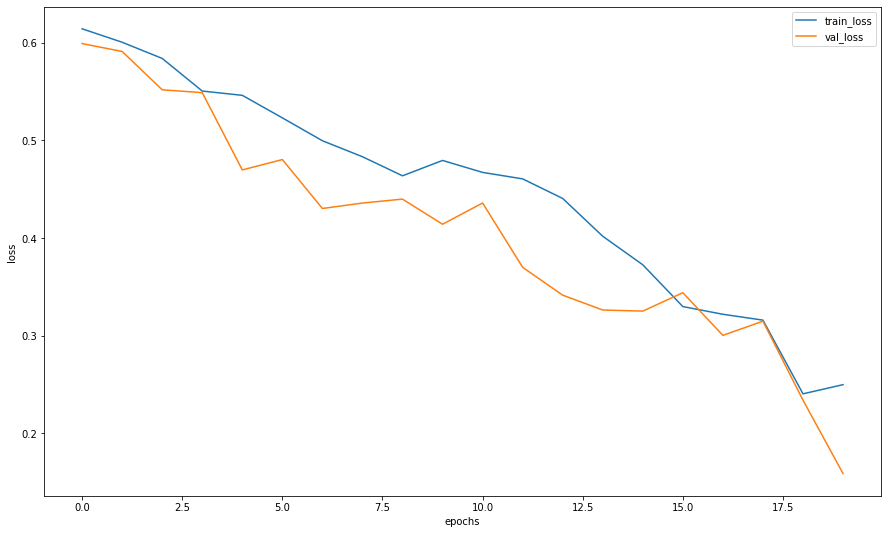

In [114]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Ну вот, совсем другое дело - точность 95% нам вполне подойдёт



# Сохраним веса получившейся модели


In [ ]:
torch.save(simple_cnn.state_dict(), "/content/gdrive/MyDrive/ups_2022_circle/weights.pth")